Steps:


1. Read data.
2. Train test splits.
3. Split train in multiple fragments 50, 100, ..., 20k


4. Train Ridge / dummy regressor on field.
5. Train NeRF on train split.
5. record the two performances on test set.

# Zip code analysis / geographical region investigation

In [1]:
import numpy as np
# train_percentages = np.arange(10, 101, 10)
train_percentages = np.arange(100, 101, 10)
train_percentages

array([100])

# 0. Data Preparation / Physicial location Splits 


In [2]:
# 1. Read data.
from utils.scripts.architectures.train_location_encoder import process_locations_visibility_data_frame
import numpy as np
import pandas as pd

data_loc = "./utils/assets/data"

# vis_df_n, norm_params, non_empty_classes = process_locations_visibility_data_frame(f"{data_loc}/locations.csv")

# vis_raw_df = pd.read_csv(f"{data_loc}/locations.csv")
vis_raw_df = pd.read_csv(f"{data_loc}/fullVisibilityData_11182024.csv")
# np.random.seed(1)
# vis_raw_df = vis_raw_df.sample(frac=1)
# splits_folder_name = "splits_physical"
splits_folder_name = "semantics_final"


In [3]:
# vis_raw_df.shape[0]/6
# (vis_raw_df.shape[0] * .19), (vis_raw_df.shape[0] * .20), 15000/6

# num_test_physical_locations = 800
num_test_physical_locations = 2500

In [4]:
#Physical location shuffling:

#1. location indexes sorted based on total number of locations
location_indexes = np.arange(vis_raw_df.shape[0] // 6) #6 directions for each camera locations
#1.b. shuffle location indexes
np.random.seed(1)
np.random.shuffle(location_indexes) #Inplace shuffling
location_indexes
print(f"Detected {len(location_indexes):,} physical locations and shuffled their order.")


#2.a. test indexes are the first 800 (18% of 4372 total locations) shuffled locations indexes
test_indexes = location_indexes[:num_test_physical_locations]
#2.b train indexes are [800:] - based on training_percentages define train indexes splits
full_train_indexes = location_indexes[num_test_physical_locations:]
print(f"Splited in {len(full_train_indexes):,} train and {len(test_indexes):,} test locations.")


#3. sort vis_df by x,y,z. 
vis_df_n = vis_raw_df.sort_values(by=["x", "y", "z"]).reset_index(drop=True)
print("Sorted data frame by physical location.")

#4. map location indexes to tuples of 6 rows.
test_sample_indexes = [i for ti in test_indexes for i in (np.arange(6) + 6 * ti)]
test_df = vis_df_n.take(test_sample_indexes)
print(f"\nTaken {test_df.shape[0]:,} test samples according to the {len(test_indexes)} test location indexes.")
file_name = f"{data_loc}/{splits_folder_name}/test_set_{test_df.shape[0]}"
test_df.to_csv(f"{file_name}.csv", index=False)
test_df, _, _ = process_locations_visibility_data_frame(f"{file_name}.csv")
test_df.to_json(f"{file_name}.json", orient="records", indent=4)
# test_df.to_json(f"{data_loc}/{splits_folder_name}/test_set_{test_df.shape[0]}.json", orient="records", indent=4)

full_train_sample_indexes = [i for ti in full_train_indexes for i in (np.arange(6) + 6 * ti)]
full_train_df = vis_df_n.take(full_train_sample_indexes)
print(f"Taken {full_train_df.shape[0]:,} train samples according to the {len(full_train_indexes):,} train location indexes.")
full_train_df.to_json(f"{data_loc}/{splits_folder_name}/train_set_{full_train_df.shape[0]}.json", orient="records", indent=4)


Detected 13,116 physical locations and shuffled their order.
Splited in 10,616 train and 2,500 test locations.
Sorted data frame by physical location.

Taken 15,000 test samples according to the 2500 test location indexes.
Normalizing each label value by: 518,400
Selected label indexes: [0 1 2 3 4 5 6 7] [ True  True  True  True  True  True  True  True]

Normalized f_xyz between -1 ([-1. -1. -1. -1. -1. -1. -1. -1.]) and 1 ([ 1.          1.         -0.7119213  -0.77133873  0.23229938  0.99790509
  1.         -0.99418596]), considering the maximum label row value of 518400
Taken 63,696 train samples according to the 10,616 train location indexes.


In [5]:


#5. Create train df fractions:

train_fractions = train_percentages/100
for fraction in train_fractions:
    num_train_samples = int(fraction * len(full_train_sample_indexes))
    train_df = full_train_df[:num_train_samples]
    
    file_name = f"./utils/assets/data/{splits_folder_name}/train_set_{int(fraction * 100)}-percent"
    
    np.random.seed(1)
    train_df.sample(frac=1).to_csv(f"{file_name}.csv", index=False)
    
    
    train_df, _, _ = process_locations_visibility_data_frame(f"{file_name}.csv")
    train_df.to_json(f"{file_name}.json", orient="records", indent=4)
#     break
    
print(f"\nCreated train splits for the percentages: \n\t{'%   '.join(train_percentages.astype(str))}%.")

Normalizing each label value by: 518,400
Selected label indexes: [0 1 2 3 4 5 6 7] [ True  True  True  True  True  True  True  True]

Normalized f_xyz between -1 ([-1. -1. -1. -1. -1. -1. -1. -1.]) and 1 ([ 1.          1.          0.10277392 -0.80943287  0.13684799  1.
  1.         -0.98428241]), considering the maximum label row value of 518400

Created train splits for the percentages: 
	100%.


# 1. Train simple ground truth interpolator

In [4]:
import pandas as pd


# splits_folder_name = "splits_physical"
splits_folder_name = "semantics_final"

test_df  = pd.read_json(f"{data_loc}/{splits_folder_name}/test_set_4800.json")

# 2. Train `NeRF` interpolator.

In [6]:
from utils.scripts.architectures.train_location_encoder \
import get_location_visibility_encoder, process_locations_visibility_data_frame\
, get_location_visibility_loaders, run_one_epoch_location_encoder, train_model_on_data


from utils.scripts.architectures.torch_nerf_src import network

import numpy as np
import pandas as pd
import torch


from tqdm.notebook import tqdm

data_loc   = "./utils/assets/data"
ne  = 350
sli = [0,1,5,6] #[' building' ' water' ' road ' ' sidewalk' ' surface' ' tree' ' sky']# 
# sli = [0,1,2,3,4,5,6,7]#['building', 'water', 'road ', 'sidewalk', 'surface', 'tree', 'sky', 'miscellaneous']



# train_percentages = np.arange(10, 101, 10)

for i, percentage in enumerate(train_percentages):
    print(f"{i+1}. Training on {percentage}% of the data:")
    file_store = f"{data_loc}/{splits_folder_namesplits_physical}/train_set_{percentage}-percent.csv"
    model_name = f"encoder_{percentage}.pt"
    # Train NeRF for ne epochs
    encoder_net, tr_losses_history, test_losses_history, vdf \
    = train_model_on_data(data_path=file_store, num_epochs=ne, selected_label_indexes=sli, model_name=model_name)
#     break



1. Training on 10% of the data:
Found 4 classes appearing more than 5.0%: [' building' ' water' ' tree' ' sky']
Training data percentace 100.00% - 1,714 samples, for 350 epochs:


Epoch 350 / 350- Training loss 0.13354 - test loss 0.17609: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [02:06<00:00,  2.77it/s]


Model weights saved at:
	./utils/assets/data/splits_physical/models/encoder_10.pt

Training for 
	350     epochs took: 
	126s, for an average of: 
	0.4s per epoch.
2. Training on 20% of the data:
Found 4 classes appearing more than 5.0%: [' building' ' water' ' tree' ' sky']
Training data percentace 100.00% - 3,428 samples, for 350 epochs:


Epoch 350 / 350- Training loss 0.12762 - test loss 0.16861: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [04:17<00:00,  1.36it/s]


Model weights saved at:
	./utils/assets/data/splits_physical/models/encoder_20.pt

Training for 
	350     epochs took: 
	257s, for an average of: 
	0.7s per epoch.
3. Training on 30% of the data:
Found 4 classes appearing more than 5.0%: [' building' ' water' ' tree' ' sky']
Training data percentace 100.00% - 5,143 samples, for 350 epochs:


Epoch 350 / 350- Training loss 0.11861 - test loss 0.16822: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [07:35<00:00,  1.30s/it]


Model weights saved at:
	./utils/assets/data/splits_physical/models/encoder_30.pt

Training for 
	350     epochs took: 
	455s, for an average of: 
	1.3s per epoch.
4. Training on 40% of the data:
Found 4 classes appearing more than 5.0%: [' building' ' water' ' tree' ' sky']
Training data percentace 100.00% - 6,857 samples, for 350 epochs:


Epoch 350 / 350- Training loss 0.11249 - test loss 0.15491: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [12:07<00:00,  2.08s/it]


Model weights saved at:
	./utils/assets/data/splits_physical/models/encoder_40.pt

Training for 
	350     epochs took: 
	727s, for an average of: 
	2.1s per epoch.
5. Training on 50% of the data:
Found 4 classes appearing more than 5.0%: [' building' ' water' ' tree' ' sky']
Training data percentace 100.00% - 8,572 samples, for 350 epochs:


Epoch 350 / 350- Training loss 0.10650 - test loss 0.15855: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [13:30<00:00,  2.32s/it]


Model weights saved at:
	./utils/assets/data/splits_physical/models/encoder_50.pt

Training for 
	350     epochs took: 
	811s, for an average of: 
	2.3s per epoch.
6. Training on 60% of the data:
Found 4 classes appearing more than 5.0%: [' building' ' water' ' tree' ' sky']
Training data percentace 100.00% - 10,287 samples, for 350 epochs:


Epoch 350 / 350- Training loss 0.10470 - test loss 0.14388: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [14:01<00:00,  2.40s/it]


Model weights saved at:
	./utils/assets/data/splits_physical/models/encoder_60.pt

Training for 
	350     epochs took: 
	841s, for an average of: 
	2.4s per epoch.
7. Training on 70% of the data:
Found 4 classes appearing more than 5.0%: [' building' ' water' ' tree' ' sky']
Training data percentace 100.00% - 12,001 samples, for 350 epochs:


Epoch 350 / 350- Training loss 0.10578 - test loss 0.13881: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [15:04<00:00,  2.58s/it]


Model weights saved at:
	./utils/assets/data/splits_physical/models/encoder_70.pt

Training for 
	350     epochs took: 
	905s, for an average of: 
	2.6s per epoch.
8. Training on 80% of the data:
Found 4 classes appearing more than 5.0%: [' building' ' water' ' tree' ' sky']
Training data percentace 100.00% - 13,716 samples, for 350 epochs:


Epoch 350 / 350- Training loss 0.10535 - test loss 0.13387: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [19:44<00:00,  3.39s/it]


Model weights saved at:
	./utils/assets/data/splits_physical/models/encoder_80.pt

Training for 
	350     epochs took: 
	1,185s, for an average of: 
	3.4s per epoch.
9. Training on 90% of the data:
Found 4 classes appearing more than 5.0%: [' building' ' water' ' tree' ' sky']
Training data percentace 100.00% - 15,430 samples, for 350 epochs:


Epoch 350 / 350- Training loss 0.10587 - test loss 0.15024: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [11:18<00:00,  1.94s/it]


Model weights saved at:
	./utils/assets/data/splits_physical/models/encoder_90.pt

Training for 
	350     epochs took: 
	679s, for an average of: 
	1.9s per epoch.
10. Training on 100% of the data:
Found 4 classes appearing more than 5.0%: [' building' ' water' ' tree' ' sky']
Training data percentace 100.00% - 17,145 samples, for 350 epochs:


Epoch 350 / 350- Training loss 0.10460 - test loss 0.13126: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [11:25<00:00,  1.96s/it]

Model weights saved at:
	./utils/assets/data/splits_physical/models/encoder_100.pt

Training for 
	350     epochs took: 
	685s, for an average of: 
	2.0s per epoch.


# 2.b Compute `NeRF` predictions

In [30]:
from tqdm import tqdm
# train_percentages = np.arange(10, 101, 10)

# Initialize NeRFS model with weights of trainedNeRF model
model_path      = f"./utils/assets/data/{splits_folder_name}/models"
info_dict       = pd.read_json(f"{model_path}/training_info_350.json").to_dict()[0]
norm_params                = (torch.tensor(info_dict["xyz_centroid"]), torch.tensor(info_dict["xyz_max-min"]), torch.tensor(info_dict["xyzh_centroid"]), torch.tensor(info_dict["xyzh_max-min"]))
    
nerf_predictions_per_percentage = {}
nerf_predictions = []

for i, percentage in tqdm(enumerate(train_percentages)):
    trained_encoder            = network.nerfs.NeRFS(norm_params=norm_params, surface_type="square", pos_dim=info_dict["enc_input_size"], output_dim=info_dict["num_present_classes"],  view_dir_dim=info_dict["enc_input_size"])
    trained_encoder.load_state_dict(torch.load(f"{model_path}/encoder_{percentage}.pt"))
    
    for i in range(test_df.shape[0]):
        xyz  = torch.tensor(test_df.values[:,:6][i].astype(float)[:3])
        xyzh = torch.tensor(test_df.values[:,:6][i].astype(float)[3:])

        _,_, prediction = trained_encoder.predict_from_raw(xyz, xyzh)


        nerf_predictions.append(prediction.detach().numpy()[0])
    
    nerf_predictions = np.vstack(nerf_predictions)
    nerf_predictions_per_percentage[percentage] = nerf_predictions
    nerf_predictions = []
    
# nerf_predictions.shape

0it [00:00, ?it/s]

Surface not initialized properly. Can only predict from raw position and direction.


1it [00:15, 15.22s/it]

Surface not initialized properly. Can only predict from raw position and direction.


2it [00:31, 15.74s/it]

Surface not initialized properly. Can only predict from raw position and direction.


3it [00:46, 15.53s/it]

Surface not initialized properly. Can only predict from raw position and direction.


4it [01:01, 15.35s/it]

Surface not initialized properly. Can only predict from raw position and direction.


5it [01:16, 15.19s/it]

Surface not initialized properly. Can only predict from raw position and direction.


6it [01:31, 15.23s/it]

Surface not initialized properly. Can only predict from raw position and direction.


7it [01:47, 15.28s/it]

Surface not initialized properly. Can only predict from raw position and direction.


8it [02:02, 15.25s/it]

Surface not initialized properly. Can only predict from raw position and direction.


9it [02:18, 15.39s/it]

Surface not initialized properly. Can only predict from raw position and direction.


10it [02:33, 15.34s/it]


# 3.  comparison between `NeRF` and vanilla interpolator

# Try a number of different vanilla regressors:

In [36]:
# 4. Train Ridge / dummy regressor on field.

import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

vanilla_predictors = {
                    "1 Neighbor" : KNeighborsRegressor(n_neighbors=1),\
                    "2 Neighbors" : KNeighborsRegressor(n_neighbors=2),\
                    "3 Neighbors" : KNeighborsRegressor(n_neighbors=3),\
                    "4 Neighbors" : KNeighborsRegressor(n_neighbors=4),\
                    "5 Neighbors" : KNeighborsRegressor(n_neighbors=5),\
                    "6 Neighbors" : KNeighborsRegressor(n_neighbors=6),\
                    "7 Neighbors" : KNeighborsRegressor(n_neighbors=7),\
                    "10 Neighbors" : KNeighborsRegressor(n_neighbors=10),\
                    "15 Neighbors" : KNeighborsRegressor(n_neighbors=15),\
                    "20 Neighbors" : KNeighborsRegressor(n_neighbors=20),\
#                     "50 Neighbors" : KNeighborsRegressor(n_neighbors=50),\
#                      "Random Forest" : RandomForestRegressor(max_depth=7, random_state=0),
#                      "Ridge" : Ridge(alpha=1.0),\
                     }

predictors_map = {}

for predictor_name in vanilla_predictors:
    print(f"{predictor_name} test:")
    
    predictor = vanilla_predictors[predictor_name]
    
    vanilla_predictions_per_percentage = {}
    vanilla_predictions = []


    test_df  = pd.read_json(f"{data_loc}/{splits_folder_name}/test_set_4800.json")
    X_test = test_df[["xn", "yn", "zn", "xhn", "yhn", "zhn"]].values
    y_test = np.vstack(test_df["f_xyz"].values)

    for percentage in tqdm(train_percentages):

        train_df = pd.read_json(f"{data_loc}/{splits_folder_namesplits_physical}/train_set_{percentage}-percent.json")

        X = train_df[["xn", "yn", "zn", "xhn", "yhn", "zhn"]].values
        y = np.vstack(train_df["f_xyz"].values)

        predictor.fit(X, y)

        vanilla_predictions = predictor.predict(X_test)

        vanilla_predictions_per_percentage[percentage] = vanilla_predictions
    
    predictors_map[predictor_name] = vanilla_predictions_per_percentage


1 Neighbor test:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.08it/s]


2 Neighbors test:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.33it/s]


3 Neighbors test:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.69it/s]


4 Neighbors test:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.87it/s]


5 Neighbors test:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.13it/s]


6 Neighbors test:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.73it/s]


7 Neighbors test:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.11it/s]


10 Neighbors test:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.23it/s]


15 Neighbors test:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.94it/s]


20 Neighbors test:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.39it/s]


# 3.b. Criterion comparisons between NeRF and vanilla interpolator¶

10it [00:00, 9506.58it/s]
10it [00:00, 3247.87it/s]
10it [00:00, 5938.42it/s]
10it [00:00, 2901.03it/s]
10it [00:00, 2247.75it/s]


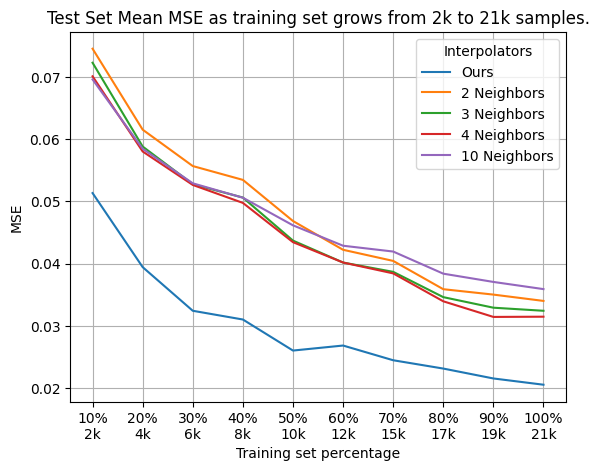

In [42]:
import torch
criterion   = torch.nn.MSELoss(reduction='none')
y_test = np.vstack(test_df["f_xyz"].values)

nerf_mses = []
vanilla_mses = []
vanilla_mses_per_predictor = {}

# Compute criterion for both NERF and Vanilla.
#Needs to already be computed:
#1. vanilla_predictions_per_percentage
#2. nerf_predictions_per_percentage

for i, percentage in tqdm(enumerate(train_percentages)):
    nerf_predictions = nerf_predictions_per_percentage[percentage]
    nerf_mse         = criterion(torch.tensor(nerf_predictions), torch.tensor(y_test)).mean()

    nerf_mses.append(nerf_mse.detach().numpy())

for predictor_name in list(predictors_map.keys()):#[::-1]:
    if predictor_name in ["Ridge", "Random Forest", "20 Neighbors", "15 Neighbors"\
                          , "7 Neighbors", "6 Neighbors", "5 Neighbors", "1 Neighbor"]:
        continue
    
    vanilla_predictions_per_percentage = predictors_map[predictor_name]
    
    for i, percentage in tqdm(enumerate(train_percentages)):
        vanilla_predictions = vanilla_predictions_per_percentage[percentage]
        vanilla_mse         = criterion(torch.tensor(vanilla_predictions), torch.tensor(y_test)).mean()

        vanilla_mses.append(vanilla_mse.detach().numpy())
        
    vanilla_mses_per_predictor[predictor_name] = vanilla_mses
    vanilla_mses = []
    
#     if predictor_name == "2 Neighbors":
#         predictor_name = 

import matplotlib.pyplot as plt

plt.plot(nerf_mses, label="Ours")
for predictor_name in vanilla_mses_per_predictor:
    vanilla_mses = vanilla_mses_per_predictor[predictor_name]
    plt.plot(vanilla_mses, label=predictor_name)
plt.legend(title="Interpolators")

num_train_samples_str = (train_df.shape[0] * train_percentages/100).astype(int).astype(str)
num_samples_in_k      = [f"{s[:-3]}k" for s in num_train_samples_str]

plt.xticks(np.arange(len(nerf_mses)), labels=[f"{tp}%\n{nk}" for \
                                              tp, nk in zip(train_percentages, num_samples_in_k)])
plt.xlabel("Training set percentage")
plt.ylabel("MSE")
plt.title("Test Set Mean MSE as training set grows from 2k to 21k samples.")
plt.grid()


plt.show()

In [33]:
vanilla_mses_per_predictor, nerf_mses

({'2 Neighbors': [array(0.07448182),
   array(0.06148795),
   array(0.0556464),
   array(0.05342686),
   array(0.04682428),
   array(0.04220485),
   array(0.0404186),
   array(0.035877),
   array(0.03501105),
   array(0.03399733)],
  '5 Neighbors': [array(0.06795554),
   array(0.05744756),
   array(0.05187696),
   array(0.05011879),
   array(0.0441432),
   array(0.04042518),
   array(0.0385951),
   array(0.03492178),
   array(0.03247029),
   array(0.03184269)],
  '10 Neighbors': [array(0.06955068),
   array(0.05842049),
   array(0.0528776),
   array(0.0505654),
   array(0.04613081),
   array(0.0428561),
   array(0.04192284),
   array(0.03837071),
   array(0.03704432),
   array(0.03589184)]},
 [array(0.05130732),
  array(0.03941988),
  array(0.03241356),
  array(0.03101142),
  array(0.0260278),
  array(0.02683409),
  array(0.02447186),
  array(0.02313715),
  array(0.0215481),
  array(0.02054334)])

In [51]:
num_train_samples_str = (train_df.shape[0] * train_percentages/100).astype(int).astype(str)
num_samples_in_k = [f"{s[:-3]}k" for s in num_train_samples_str]
num_samples_in_k

['2k', '4k', '6k', '8k', '10k', '12k', '14k', '16k', '19k', '21k']

In [49]:
train_percentages, (train_df.shape[0] * train_percentages/100).astype(int).astype(str)

(array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100]),
 array(['2123', '4246', '6369', '8492', '10616', '12739', '14862', '16985', '19108', '21232'], dtype='<U21'))

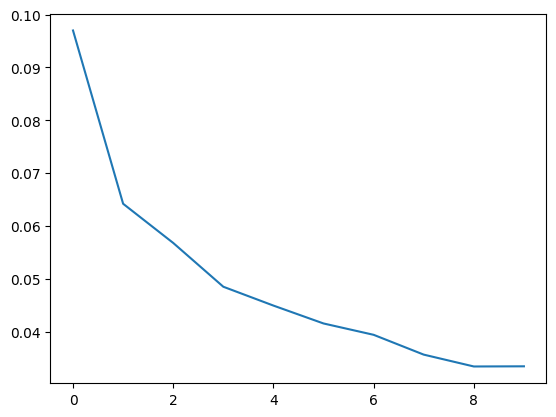

In [36]:
criterion(torch.tensor(nerf_predictions), torch.tensor(y_test)).mean()\
          , criterion(torch.tensor(vanilla_predictions), torch.tensor(y_test)).mean()

(tensor(0.0420, dtype=torch.float64), tensor(0.1628, dtype=torch.float64))

In [39]:
criterion(torch.tensor(nerf_predictions), torch.tensor(y_test)).mean(axis=1).mean()\
          , criterion(torch.tensor(vanilla_predictions), torch.tensor(y_test)).mean(axis=1).mean()

(tensor(0.0420, dtype=torch.float64), tensor(0.1628, dtype=torch.float64))

In [38]:
criterion(torch.tensor(nerf_predictions), torch.tensor(y_test)).mean(axis=0)\
          , criterion(torch.tensor(vanilla_predictions), torch.tensor(y_test)).mean(axis=0)

(tensor([0.0762, 0.0137, 0.0344, 0.0437], dtype=torch.float64),
 tensor([0.3179, 0.0571, 0.0746, 0.2015], dtype=torch.float64))

# 4. Replicate interpolation test for multiple training percentages and models.

# Drafts

In [33]:
criterion   = torch.nn.MSELoss(reduction='none')

criterion(torch.tensor(nerf_predictions[0]), torch.tensor(y_test[0]))\
          , criterion(torch.tensor(vanilla_predictions[0]), torch.tensor(y_test[0])),\
criterion(torch.tensor(nerf_predictions[0]), torch.tensor(y_test[0])).mean()\
          , criterion(torch.tensor(vanilla_predictions[0]), torch.tensor(y_test[0])).mean()

(tensor([4.7924e-03, 1.8183e-07, 2.3490e-02, 8.3328e-04], dtype=torch.float64),
 tensor([2.6367, 0.0028, 0.2110, 1.0106], dtype=torch.float64),
 tensor(0.0073, dtype=torch.float64),
 tensor(0.9653, dtype=torch.float64))

In [29]:
nerf_predictions[0], vanilla_predictions[0], y_test[0]

(array([ 0.8190328 , -0.9995736 , -0.8460536 , -0.91780937], dtype=float32),
 array([-0.735547  , -0.94720399, -0.54001446,  0.11634165]),
 array([ 0.88825989, -1.        , -0.99931717, -0.88894272]))

# Test `NeRFS` and `NeRF` return the same resutls

In [44]:
import torch

xyz  = torch.tensor(vdf.values[:,:6][0].astype(float)[:3])
xyzh = torch.tensor(vdf.values[:,:6][0].astype(float)[3:])

#1. NeRF - !needs normalized inputs.
norm_pos = (xyz - norm_params[0]) / norm_params[1]
pos      = norm_pos.unsqueeze(0)
view_dir = (xyzh - norm_params[2]) / norm_params[3]
view_dir = view_dir.unsqueeze(0)

print("NeRF prediction")
print(xyz, xyzh, encoder_net(pos, view_dir, from_raw=True)) #NeRF needs normalized inputs.


#2. NeRFS 
print("\nNeRFS prediction")
print(trained_encoder.predict_from_raw(xyz, xyzh))

NeRF prediction
tensor([2152.9542,   23.2385,  958.9914], dtype=torch.float64) tensor([ 7.3868, 80.1305, -7.2787], dtype=torch.float64) tensor([[-0.4327, -0.7639, -0.6330, -0.2706]], grad_fn=<TanhBackward0>)

NeRFS prediction
(tensor([2152.9542,   23.2385,  958.9914], dtype=torch.float64), tensor([ 7.3868, 80.1305, -7.2787], dtype=torch.float64), tensor([[-0.4327, -0.7639, -0.6330, -0.2706]], grad_fn=<TanhBackward0>))


In [ ]:

train_df[["xn", "yn", "zn", "xhn", "yhn", "zhn"]].values.shape
np.vstack(train_df["f_xyz"].values).shape

In [ ]:

n_samples, n_features = 10, 5
rng = np.random.RandomState(0)
y = rng.randn(n_samples)
X = rng.randn(n_samples, n_features)
clf = Ridge(alpha=1.0)
clf.fit(X, y)

# Original data splits not considering separate physical locations in train and test

In [6]:
# 1. Read data.
from utils.scripts.architectures.train_location_encoder import process_locations_visibility_data_frame
import numpy as np
import pandas as pd

data_loc = "./utils/assets/data"

vis_df_n, norm_params, non_empty_classes = process_locations_visibility_data_frame(f"{data_loc}/locations.csv")

vis_raw_df = pd.read_csv(f"{data_loc}/locations.csv")
# np.random.seed(1)
# vis_raw_df = vis_raw_df.sample(frac=1)

# 2. Train test splits.
np.random.seed(1)
visual_df = vis_df_n.sample(frac=1)
visual_df.to_json(f"{data_loc}/splits/full_dataset_{visual_df.shape[0]}.json", orient="records", indent=4)
test_df       = visual_df[:5000]
full_train_df = visual_df[5000:]
test_df.to_json(f"{data_loc}/splits/test_set_{test_df.shape[0]}.json", orient="records", indent=4)

# 3. Split train in multiple fragments 50, 100, ..., 20k
train_fractions = train_percentages/100#[1, .8, .6, .4, .2, .1]

for fraction in train_fractions:
    num_train_samples = int(fraction * full_train_df.shape[0])
    train_df = full_train_df[:num_train_samples]
    
    file_name = f"./utils/assets/data/splits/train_set_{int(fraction * 100)}-percent"
    train_df.to_json(f"{file_name}.json", orient="records", indent=4)
    
    vis_raw_df[5000:5000+num_train_samples].to_csv(f"{file_name}.csv", index=False)
    



# Original Interpolator experiment

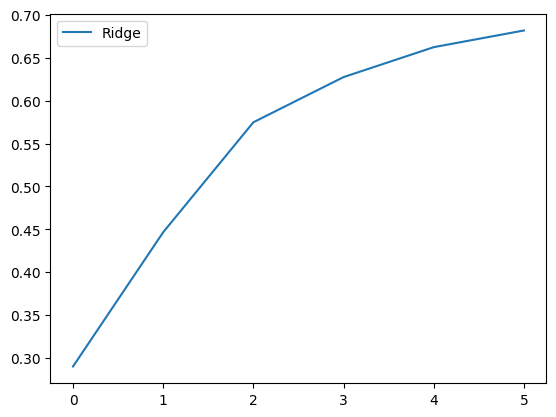

In [5]:
# 4. Train Ridge / dummy regressor on field.

from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
import numpy as np
import matplotlib.pyplot as plt



train_percentages = [10, 20, 40, 60, 80, 100]

r2_scores = []


# for i, percentage in tqdm(enumerate(train_percentages)):

for percentage in train_percentages:
    
#     test_df  = pd.read_json(f"{data_loc}/splits/test_set_5000.json")
#     train_df = pd.read_json(f"{data_loc}/splits/train_set_{percentage}-percent.json")

    test_df  = pd.read_json(f"{data_loc}/{splits_folder_name}/test_set_4800.json")
    train_df = pd.read_json(f"{data_loc}/{splits_folder_name}/train_set_{percentage}-percent.json")

    X = train_df[["xn", "yn", "zn", "xhn", "yhn", "zhn"]].values
    y = np.vstack(train_df["f_xyz"].values)

    #clf = Ridge(alpha=1.0)
    clf = KNeighborsRegressor(2)
    clf.fit(X, y)

    X_test = test_df[["xn", "yn", "zn", "xhn", "yhn", "zhn"]].values
    y_test = np.vstack(test_df["f_xyz"].values)

    r2_score = clf.score(X_test, y_test)
    r2_scores.append(r2_score)

    
vanilla_predictions = clf.predict(X_test)
vanilla_predictions.shape    

plt.plot(r2_scores, label="Ridge")
plt.legend()
plt.show()

